In [1]:
import itertools
import numpy as np
import pandas as pd
from time import process_time
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# importing the tensorflow.keras libraries and packages
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.utils import np_utils
from keras.models import Sequential
from keras.models import load_model
from keras.layers import concatenate
from keras.callbacks import CSVLogger
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Dense, LSTM, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Dropout

# importing the sklearn libraries and packages
import sklearn
from sklearn.metrics import jaccard_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report, accuracy_score


In [2]:
# load dataset
# data_path = "../Dataset/muticlass/dataset_muticlass.csv"
data_path = "../Dataset/dataset_muticlass_test.csv"
dataset = pd.read_csv(data_path)  # read the raw dataset into data-frame
df_raw = dataset.copy()

sklearn.utils.shuffle(df_raw)  # shuffle df order
X, y = df_raw.iloc[:, :-1], df_raw.iloc[:, -1]  # split feature, target arrays 

# split dataset: training set-80% testing set-20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=2022)

# Standardisation
SCALE_IN = StandardScaler()
SCALE_IN.fit(X_train)
X_train = SCALE_IN.transform(X_train)
X_test = SCALE_IN.transform(X_test)

In [3]:
features_num = X_test.shape[1]  # the number of features
class_num = len(np.unique(y_train))  # the number of categories

# One-hot encoding conversion for labels
Y_train = np_utils.to_categorical(y_train, class_num)
Y_test = np_utils.to_categorical(y_test, class_num)

# reshape for CNN
X_train_CNN = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1], 1))
X_test_CNN = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1], 1))

# reshape for LSTM
X_train_LSTM = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test_LSTM = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [4]:
# CNN
CNN_model = Sequential()
CNN_model.add(Conv2D(512, kernel_size=(3, 3), activation='tanh', padding='same', input_shape=(1, features_num, 1)))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model.add(Conv2D(256, (3, 3), activation='tanh', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))
CNN_model.add(Conv2D(128, (3, 3), activation='tanh', padding='same'))
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 512
CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 512
CNN_model.add(Conv2D(64, (3, 3), activation='tanh', padding='same'))  # 512
CNN_model.add(BatchNormalization())
CNN_model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))
CNN_model.add(Flatten())

In [5]:
# LSTM
LSTM_model = Sequential() #  climate-based model
LSTM_model.add(LSTM(units=512, return_sequences = True, input_shape = (features_num, 1), activation='tanh'))
LSTM_model.add(LSTM(units=256, return_sequences = True))
LSTM_model.add(Dense(128, activation='relu'))
LSTM_model.add(Dense(64, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Dense(32, activation='relu'))
LSTM_model.add(Dropout(0.2))
LSTM_model.add(Flatten())

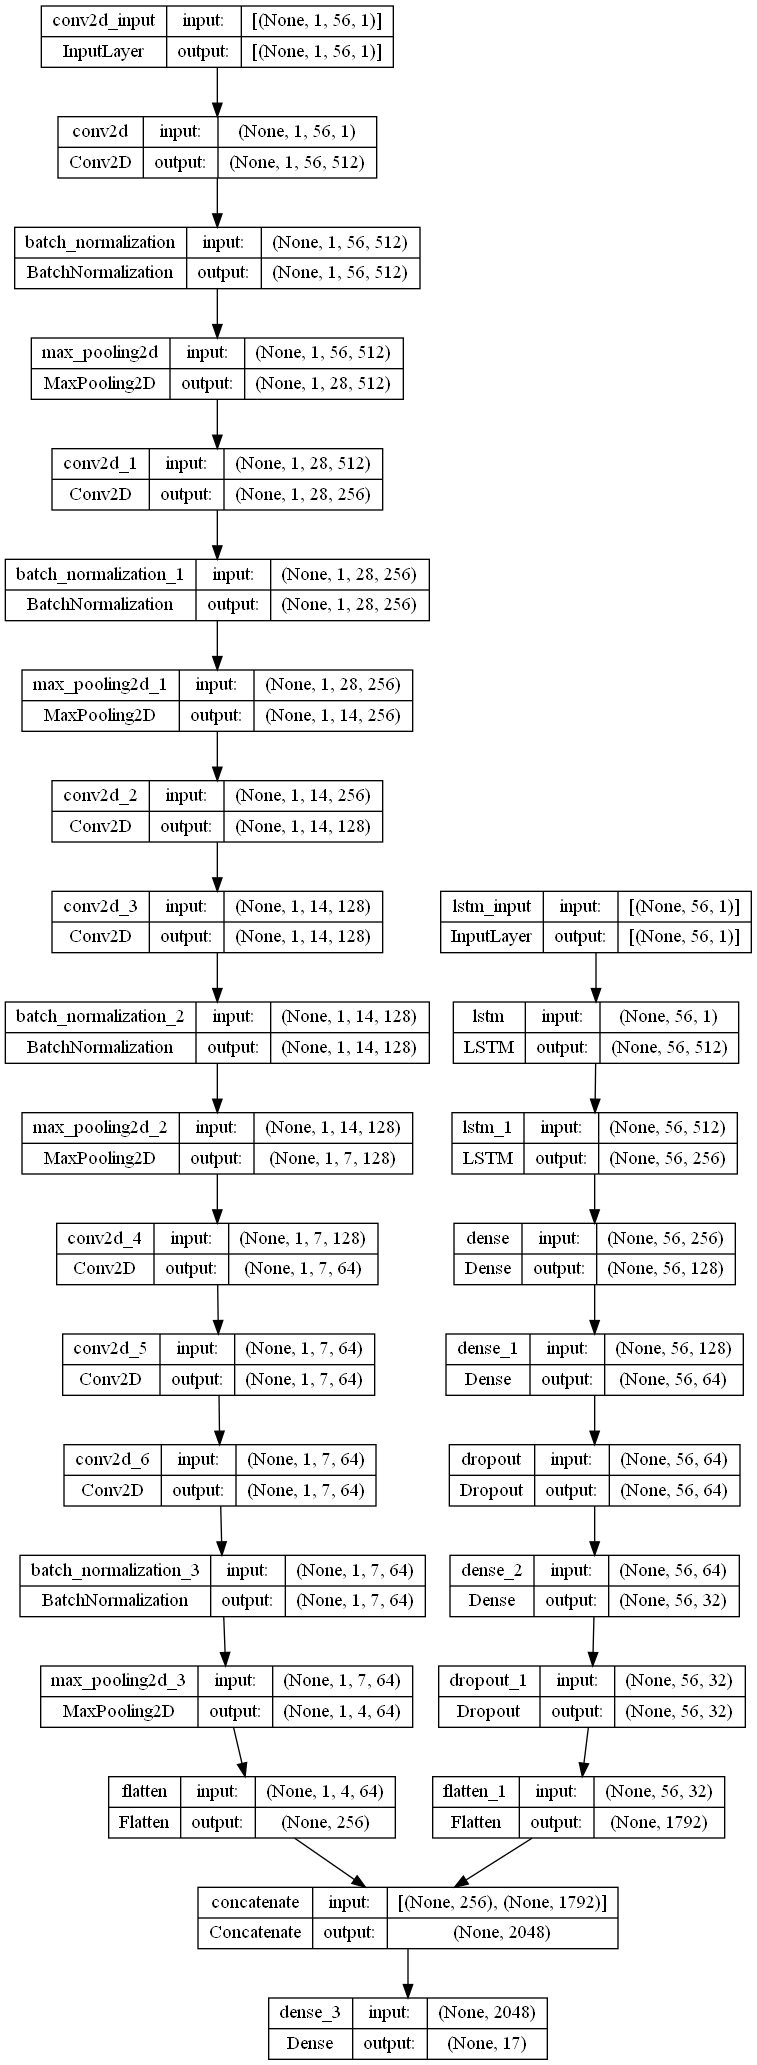

In [6]:
# concat CNN and LSTM to be a model
output = concatenate([CNN_model.output, LSTM_model.output], axis=-1)
output_model = (Dense(class_num, activation='softmax'))(output) 
model_combine = Model(inputs=[CNN_model.input, LSTM_model.input], outputs=output_model)

plot_model(model_combine, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [7]:
model_combine.compile(loss=keras.losses.binary_crossentropy, optimizer='RMSprop', metrics=['accuracy'])  

# training log - epoch, accuracy, loss, val_accuracy, val_loss
csv_logger = CSVLogger('../Logs/LSTM_CNN_Muti_train.log', separator=',', append=False)

# save and load the completed training model
checkpoint  = ModelCheckpoint('../Models/CNN_LSTM_Muti' + '.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

# reduce learning rates when evaluation indicators are not being raised
keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, mode='auto')

In [8]:
# training CNN_LSTM model
CNN_LSTM_history = model_combine.fit([X_train_CNN, X_train_LSTM], Y_train, 
                                     batch_size=128, epochs=10, 
                                     validation_data=([X_test_CNN, X_test_LSTM] , Y_test), 
                                     callbacks=[reduce_lr, checkpoint, csv_logger])

Epoch 1/10
8708/8708 [==============================] - ETA: 0s - loss: 0.0072 - accuracy: 0.9825
Epoch 1: val_loss improved from inf to 0.00406, saving model to ../Models\CNN_LSTM_Muti.h5
8708/8708 [==============================] - 306s 34ms/step - loss: 0.0072 - accuracy: 0.9825 - val_loss: 0.0041 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 2/10
8708/8708 [==============================] - ETA: 0s - loss: 0.0043 - accuracy: 0.9898
Epoch 2: val_loss did not improve from 0.00406
8708/8708 [==============================] - 301s 35ms/step - loss: 0.0043 - accuracy: 0.9898 - val_loss: 0.0257 - val_accuracy: 0.8925 - lr: 0.0010
Epoch 3/10
8708/8708 [==============================] - ETA: 0s - loss: 0.0044 - accuracy: 0.9899
Epoch 3: val_loss did not improve from 0.00406
8708/8708 [==============================] - 306s 35ms/step - loss: 0.0044 - accuracy: 0.9899 - val_loss: 0.0056 - val_accuracy: 0.9884 - lr: 0.0010
Epoch 4/10
8708/8708 [==============================] - ETA: 0s - loss: 0.

In [9]:
def plot_acc_loss(model_history):
    acc = model_history.history['accuracy']
    val_acc = model_history.history['val_accuracy']
    loss = model_history.history['loss']
    val_loss = model_history.history['val_loss']
    epochs = range(len(acc))
    
    # plot training accuracy
    plt.plot(epochs, acc, 'r', label='train_acc')
    plt.plot(epochs, val_acc, 'b', label='Validation_acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    
    # plot training loss
    plt.plot(epochs, loss, 'r', label='training_loss')
    plt.plot(epochs, val_loss, 'b', label='Validation_loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

    print(np.max(model_history.history['accuracy']))
    print(np.max(model_history.history['val_accuracy']))
    

def plot_confusion_matrix(y_test, y_pred, classes, title='Confusion Matrix', cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'.
    """
    cm = confusion_matrix(y_test, y_pred)  # calculate confusion matrix
    # print(cm)
    
    # plot the heat map for confusion matrix 
    plt.figure()
    plt.figure(figsize=(12, 12))  #s set plot size
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return cm


def models_evaluate(model, class_num, X_test_CNN, X_train_CNN, X_test_LSTM,  X_train_LSTM, Y_test):
    """
    """
    # using modle to predict results
    predict_prob = model.predict([X_test_CNN, X_test_LSTM])

    #  returns the maximum value for every row
    y_pred = np.argmax(predict_prob, axis=1)
    y_true = np.argmax(Y_test, axis=1)

    # calculate Confusion Matrix and plot heatmap
    CM = plot_confusion_matrix(y_true, y_pred, classes=list(range(class_num)), title='Confusion Matrix')
    acc_score = accuracy_score(y_test, y_pred)
    
    print('-----------------------------------------------------------------------------------------------------')
    print('Testing accuracy: {:1.5f}' .format(acc_score))
    print('-----------------------------------------------------------------------------------------------------')
    print(classification_report(y_test, y_pred, digits=5))
    print('-----------------------------------------------------------------------------------------------------')

    # calculate assessment benchmark indicators
    TN, FN, TP, FP = CM[0][0], CM[1][0], CM[1][1], CM[0][1]
    # TP, FP, TN, FN = perf_measure(y_pred, output_test.tolist())
    fp_rate = FP / (TN + FP)  # false positive rate
    tn_rate = TN / (TN + FP)  # true negative rate
    auc_val = roc_auc_score(y_true = y_pred, y_score = Y_test, multi_class='ovo')  # area under the curve

    accuracy = (TP + TN) / (TP + FP + FN + TN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = TP / (TP + FP + FN)
    iou = jaccard_score(y_true, y_pred, average='micro')  # Intersection over Union

    # print the above benchmark indicators
    print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
    print('-----------------------------------------------------------------------------------------------------')
    print('Accuracy: {:1.5f}' .format(accuracy))
    print('-----------------------------------------------------------------------------------------------------')
    print('Precision: {:1.5f}' .format(precision))
    print('-----------------------------------------------------------------------------------------------------')
    print('Recall: {:1.5f}' .format(recall))
    print('-----------------------------------------------------------------------------------------------------')
    print('F1_score: {:1.5f}' .format(f1_score))
    print('-----------------------------------------------------------------------------------------------------')
    print ('IoU: {:1.5f}' .format(iou))
    print('-----------------------------------------------------------------------------------------------------')
    print('False Positive Rate: {:1.5f}' .format(fp_rate), '\nTrue Negative Rate: {:1.5f}' .format(tn_rate))
    print('-----------------------------------------------------------------------------------------------------')

    # model_combine evaluation
    loss_train, acc_train= model_combine.evaluate([X_train_CNN, X_train_LSTM], Y_train)
    test_eval = model_combine.evaluate([X_test_CNN, X_test_LSTM], Y_test)

    print('-----------------------------------------------------------------------------------------------------')
    print('Training loss: {:1.5f}' .format(loss_train), '\nTraining accuracy: {:1.5f}' .format(acc_train))
    print('-----------------------------------------------------------------------------------------------------')
    print('Testing loss: {:1.5f}' .format(test_eval[0]), '\nTesting accuracy: {:1.5f}' .format(test_eval[1]))
    print('-----------------------------------------------------------------------------------------------------')
        

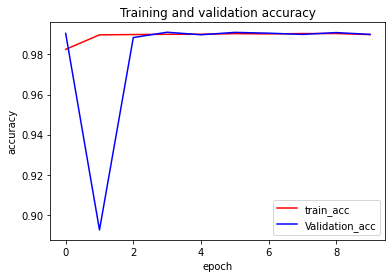

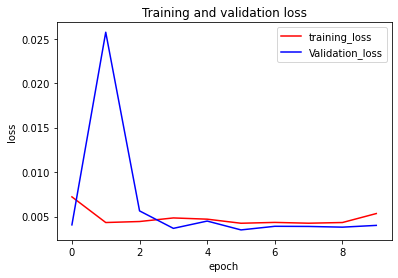

0.990404486656189
0.9910567402839661
8708/8708 [==============================] - 63s 7ms/step


<Figure size 432x288 with 0 Axes>

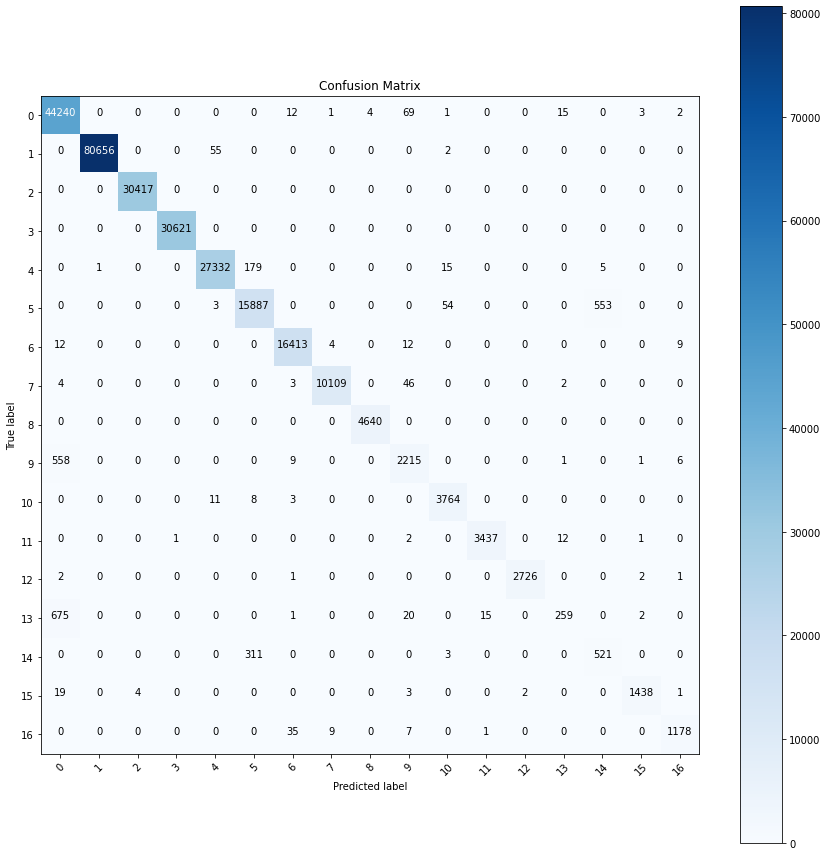

-----------------------------------------------------------------------------------------------------
Testing accuracy: 0.98998
-----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0    0.97209   0.99759   0.98468     44347
           1    0.99999   0.99929   0.99964     80713
           2    0.99987   1.00000   0.99993     30417
           3    0.99997   1.00000   0.99998     30621
           4    0.99748   0.99274   0.99510     27532
           5    0.96961   0.96302   0.96630     16497
           6    0.99612   0.99775   0.99693     16450
           7    0.99862   0.99459   0.99660     10164
           8    0.99914   1.00000   0.99957      4640
           9    0.93302   0.79391   0.85786      2790
          10    0.98046   0.99419   0.98728      3786
          11    0.99537   0.99537   0.99537      3453
          12    0.99927   0.99780   0.99853      2732
          13 

In [10]:
# plot training accuracy and loss
plot_acc_loss(CNN_LSTM_history)

models_evaluate(model_combine, class_num, X_test_CNN, X_train_CNN, X_test_LSTM,  X_train_LSTM, Y_test)

In [ ]:
predict_prob = model_combine.predict([X_test_CNN, X_test_LSTM])  # using modle predict classification results

y_pred = np.argmax(predict_prob, axis=1)
y_true = np.argmax(Y_test, axis=1)

# calculate Confusion Matrix and plot heatmap
CM = plot_confusion_matrix(y_true, y_pred, classes=list(range(class_num)), title='Confusion Matrix')

In [ ]:
print('-----------------------------------------------------------------------------------------------------')
acc_score = accuracy_score(y_test, y_pred)
print('Testing accuracy: {:1.5f}' .format(acc_score))
print('-----------------------------------------------------------------------------------------------------')
print(classification_report(y_test, y_pred, digits=5))
print('-----------------------------------------------------------------------------------------------------')

# calculate assessment benchmark indicators
TN, FN, TP, FP = CM[0][0], CM[1][0], CM[1][1], CM[0][1]
# TP, FP, TN, FN = perf_measure(y_pred, output_test.tolist())
fp_rate = FP / (TN + FP)  # false positive rate
tn_rate = TN / (TN + FP)  # true negative rate
auc_val = roc_auc_score(y_true = y_pred, y_score = Y_test, multi_class='ovo')  # area under the curve

accuracy = (TP + TN) / (TP + FP + FN + TN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = TP / (TP + FP + FN)
iou = jaccard_score(y_true, y_pred, average='micro')  # Intersection over Union

# print the above benchmark indicators
print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
print('-----------------------------------------------------------------------------------------------------')
print('Accuracy: {:1.5f}' .format(accuracy))
print('-----------------------------------------------------------------------------------------------------')
print('Precision: {:1.5f}' .format(precision))
print('-----------------------------------------------------------------------------------------------------')
print('Recall: {:1.5f}' .format(recall))
print('-----------------------------------------------------------------------------------------------------')
print('F1_score: {:1.5f}' .format(f1_score))
print('-----------------------------------------------------------------------------------------------------')
print ('IoU: {:1.5f}' .format(iou))
print('-----------------------------------------------------------------------------------------------------')
print('False Positive Rate: {:1.5f}' .format(fp_rate), '\nTrue Negative Rate: {:1.5f}' .format(tn_rate))
print('-----------------------------------------------------------------------------------------------------')

# model_combine evaluation
loss_train, acc_train= model_combine.evaluate([X_train_CNN, X_train_LSTM], Y_train)
test_eval = model_combine.evaluate([X_test_CNN, X_test_LSTM], Y_test)

print('-----------------------------------------------------------------------------------------------------')
print('Training loss: {:1.5f}' .format(loss_train), '\nTraining accuracy: {:1.5f}', format(acc_train))
print('-----------------------------------------------------------------------------------------------------')
print('Testing loss: {:1.5f}' .format(test_eval[0]), '\nTesting accuracy: {:1.5f}', format(test_eval[1]))
print('-----------------------------------------------------------------------------------------------------')

In [ ]:
# # plot receiver operating characteristic curve (ROC)
# print('-----------------------------------------------------------------------------------------------------')
# print('AUC: {:1.5f}' .format(auc_val))

# fpr, tpr, _ = roc_curve(y_true, y_pred, pos_label=15)  # roc curve
# plt.figure(figsize=(12, 12))  #s set plot size
# plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.3f)' % auc_val)  # 假正率为横坐标，真正率为纵坐标做曲线
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver operating characteristic example')
# plt.legend(loc="lower right")
# plt.show()